In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import scipy.stats as sps

sns.set()


In [3]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=' ')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    index = pd.date_range('2020-01-01',periods=len(all_deaths))
    all_deaths.index = index
    
    return all_deaths
    

df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=range(8),encoding='UTF-8')
print (df.sum())
last_data_day_idx = df.loc[df['2020'] != 0].index[-1]
last_data_day = pd.date_range('2020-01-01','2020-12-31')[last_data_day_idx].date()
last_data_day


In [6]:
df = parse_scb_prel()
last_data_day = last_day = '2020-08-07'

In [8]:
dates = pd.date_range('2020-01-01',last_day)
df.set_index(dates,inplace=True)
df.loc['2020-02-25' : '2020-03-02']

mean = df['2015-2019'].mean()
std = df['2015-2019'].std()
print (mean,std)
print (df.sum())
print (df[['2015','2019']].sum().max() - df[['2015-2019']].sum().min())


253.83112270243416 25.5855788890851
2015         56225.049180
2016         55005.945355
2017         56284.437158
2018         57237.546448
2019         53487.459016
2020         59134.000000
2015-2019    55842.846995
dtype: float64
382.20218579242646


55648.087431693995
1444.3742065656218
[55272. 56026.]
754.0
55647.98072
235.7817352728612


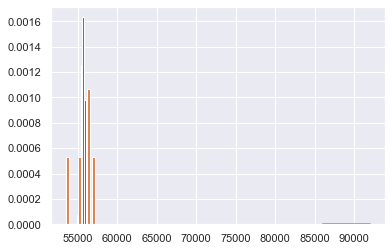

In [9]:
# random variability 954 vs diff max-min 842 vs 2020 y2d excess 2300
yearly_mean = df.loc[:,'2015' : '2019'].sum().mean()
print (yearly_mean)
yearly_std = df.loc[:,'2015' : '2019'].sum().std()
print (yearly_std)

samples = pm.rpoisson(yearly_mean,size=100000)
ci = np.percentile(samples,[5.5,94.5])
print (ci)
print (ci[1] - ci[0])
samples_mean = samples.mean()
samples_std = samples.std()

print (samples_mean)
print (samples_std)
plt.hist(samples,density=True)
plt.hist(df.loc[:,'2015':'2019'].sum(),density=True)

x = np.arange(86000,92000)
y = sps.poisson.pmf(x,mu=yearly_mean)
plt.plot(x,y)

y = sps.norm.pdf(x,yearly_mean,yearly_std)
plt.plot(x,y)


253.83112270243416 25.5855788890851


(array([1.31147541e-04, 6.80327869e-04, 4.76229508e-03, 1.32950820e-02,
        2.29262295e-02, 2.30000000e-02, 1.18442623e-02, 4.26229508e-03,
        9.91803279e-04, 7.37704918e-05]),
 array([193. , 205.2, 217.4, 229.6, 241.8, 254. , 266.2, 278.4, 290.6,
        302.8, 315. ]),
 <a list of 10 Patch objects>)

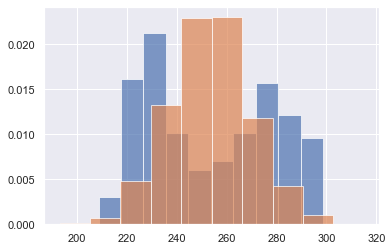

In [10]:
daily_mean = df['2015-2019'].mean()
daily_std = df['2015-2019'].std()

print (daily_mean,daily_std)
plt.hist(df['2015-2019'],density=True,alpha=0.7)

daily_samples = pm.rpoisson(daily_mean,10000)
plt.hist(daily_samples,density=True,alpha=0.7)

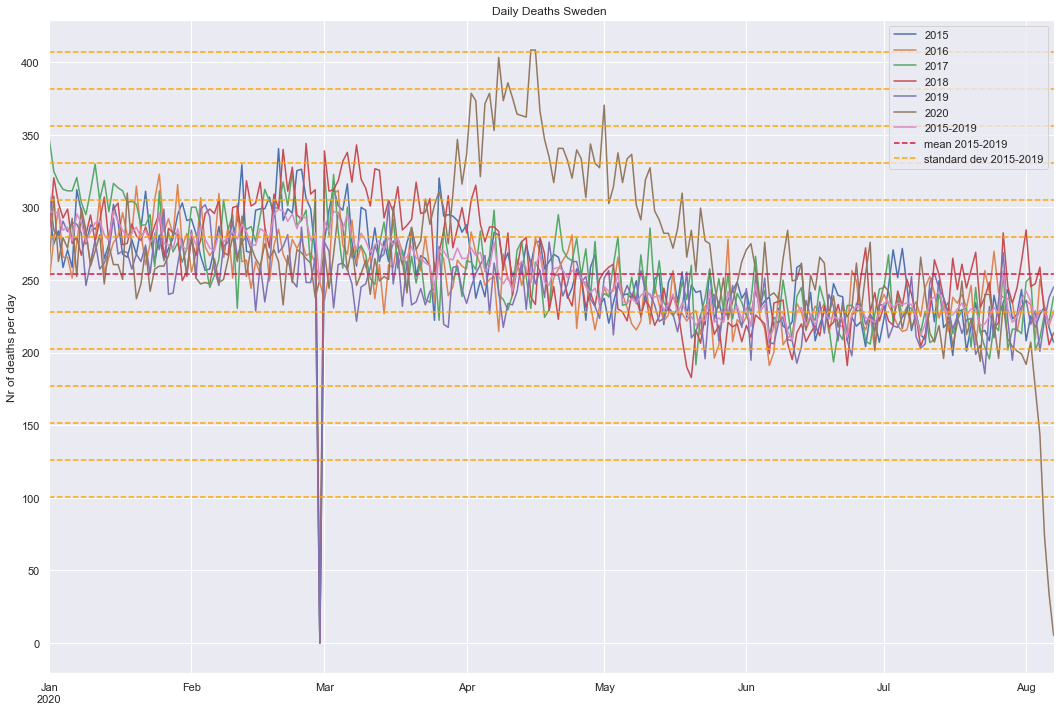

In [11]:
df.plot(figsize=(18,12))
plt.title('Daily Deaths Sweden ')
plt.axhline(mean,ls='dashed',color='crimson',label='mean 2015-2019')
plt.axhline(mean + std,ls='dashed',color='orange',label='standard dev 2015-2019')
plt.axhline(mean - std,ls='dashed',color='orange')
plt.axhline(mean + 2 * std,ls='dashed',color='orange')
plt.axhline(mean - 2 * std,ls='dashed',color='orange')
plt.axhline(mean + 3 * std,ls='dashed',color='orange')
plt.axhline(mean - 3 * std,ls='dashed',color='orange')
plt.axhline(mean + 4 * std,ls='dashed',color='orange')
plt.axhline(mean - 4 * std,ls='dashed',color='orange')
plt.axhline(mean + 5 * std,ls='dashed',color='orange')
plt.axhline(mean - 5 * std,ls='dashed',color='orange')
plt.axhline(mean + 6 * std,ls='dashed',color='orange')
plt.axhline(mean - 6 * std,ls='dashed',color='orange')
plt.ylabel('Nr of deaths per day')

plt.legend(loc='upper right')


Text(0.5, 1.0, '2020')

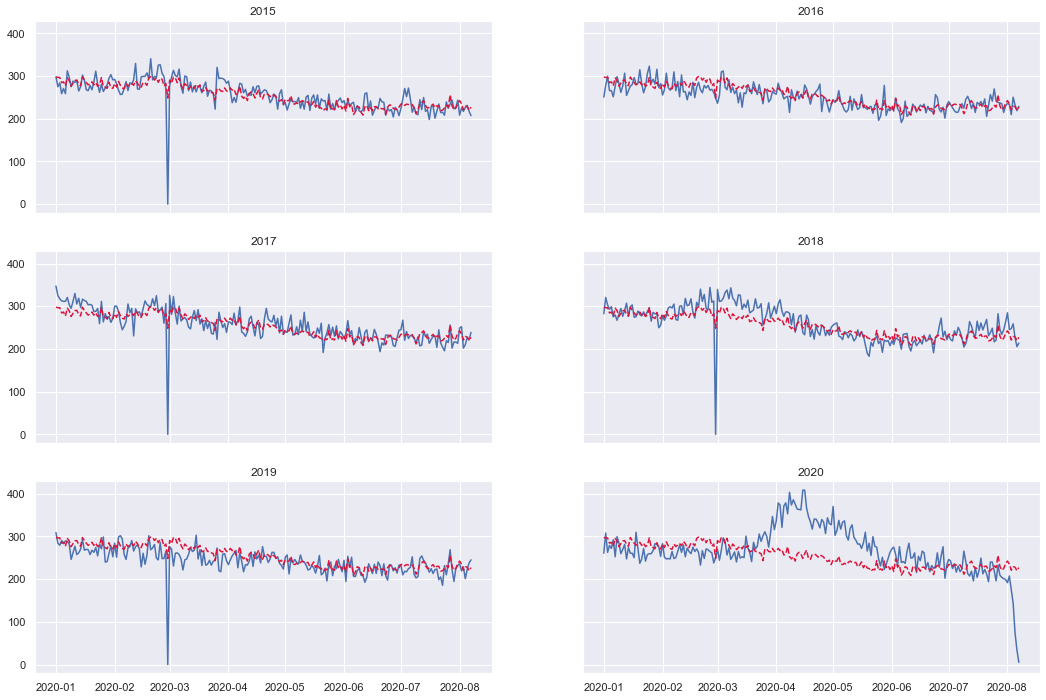

In [12]:
fig,axes = plt.subplots(3,2,sharex=True,sharey=True,figsize=(18,12))

axes[0,0].plot(df['2015'])
axes[0,0].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[0,0].set_title('2015')

axes[0,1].plot(df['2016'])
axes[0,1].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[0,1].set_title('2016')

axes[1,0].plot(df['2017'])
axes[1,0].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[1,0].set_title('2017')

axes[1,1].plot(df['2018'])
axes[1,1].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[1,1].set_title('2018')

axes[2,0].plot(df['2019'])
axes[2,0].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[2,0].set_title('2019')

axes[2,1].plot(df['2020'])
axes[2,1].plot(df['2015-2019'],ls='dashed',color='crimson')
axes[2,1].set_title('2020')


Text(0, 0.5, 'total number of deaths')

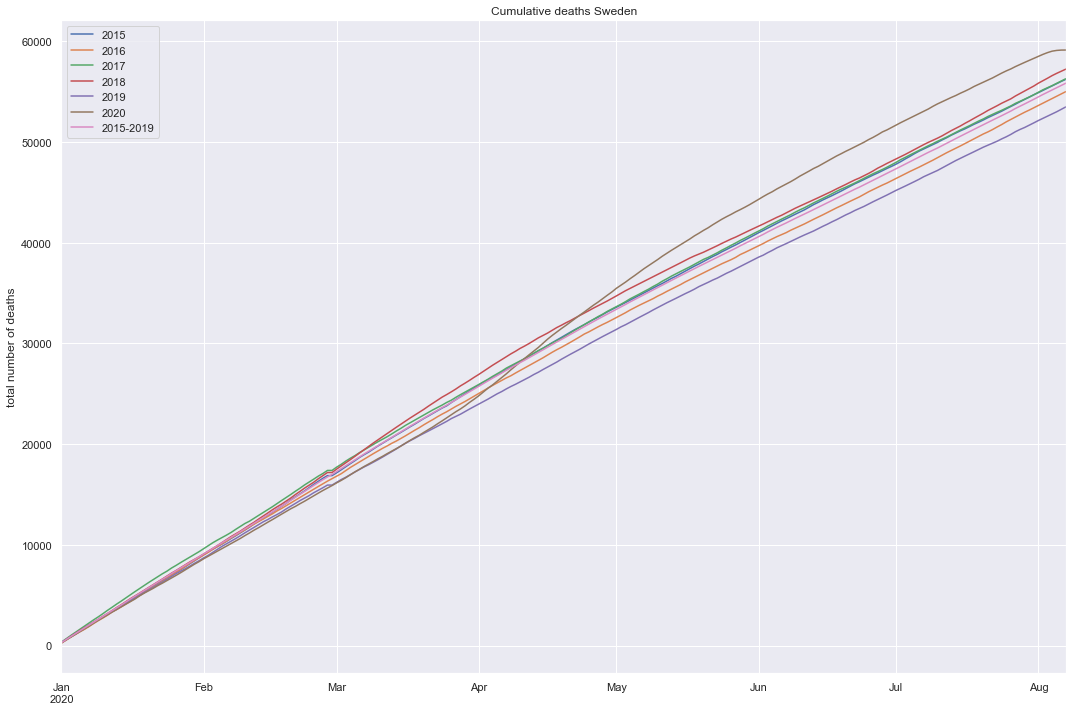

In [13]:
df.cumsum().plot(figsize=(18,12))
plt.title ('Cumulative deaths Sweden')
plt.ylabel('total number of deaths')

Text(0.5, 1.0, '2020')

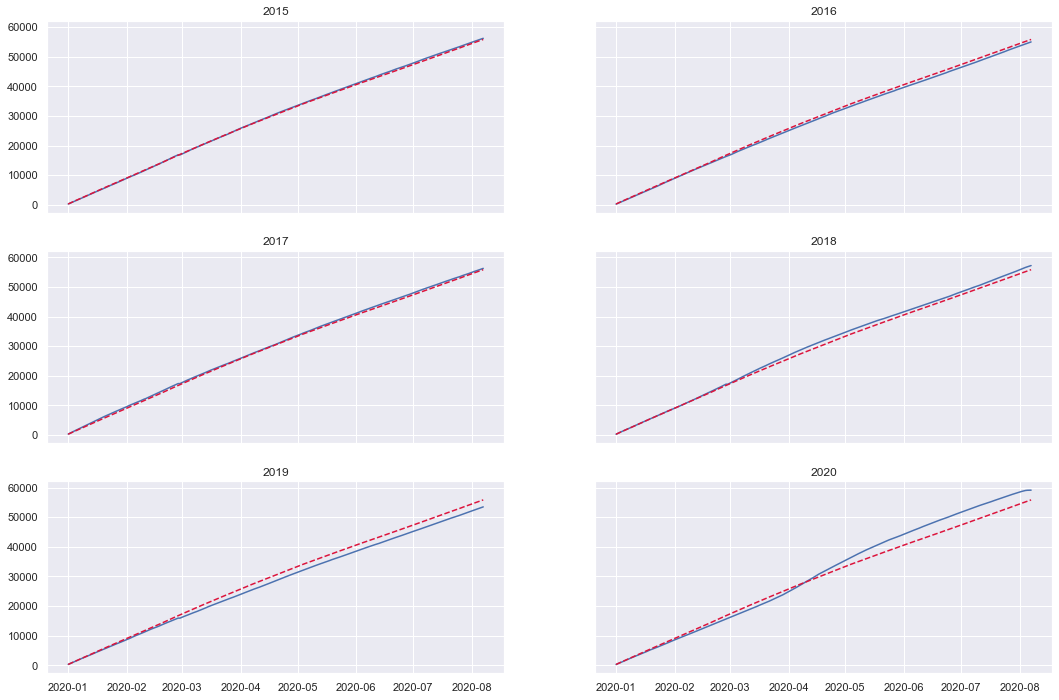

In [14]:
fig,axes = plt.subplots(3,2,sharex=True,sharey=True,figsize=(18,12))

axes[0,0].plot(df['2015'].cumsum())
axes[0,0].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[0,0].set_title('2015')

axes[0,1].plot(df['2016'].cumsum())
axes[0,1].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[0,1].set_title('2016')

axes[1,0].plot(df['2017'].cumsum())
axes[1,0].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[1,0].set_title('2017')

axes[1,1].plot(df['2018'].cumsum())
axes[1,1].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[1,1].set_title('2018')

axes[2,0].plot(df['2019'].cumsum())
axes[2,0].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[2,0].set_title('2019')

axes[2,1].plot(df['2020'].cumsum())
axes[2,1].plot(df['2015-2019'].cumsum(),ls='dashed',color='crimson')
axes[2,1].set_title('2020')


In [18]:
df.columns

Index(['2015', '2016', '2017', '2018', '2019', '2020', '2015-2019',
       'excess_deaths'],
      dtype='object')

In [19]:
df['excess_deaths'] = df['2020'] - df['2015-2019']


print (last_day)

df_until_last_day = df.loc[:last_day].copy()
df_until_last_day['cum_excess'] = df_until_last_day['excess_deaths'].cumsum()
df_until_last_day.tail(30)

cumsums = df_until_last_day[['2015-2019','2020']].cumsum()
cumsums['delta'] = cumsums['2020'] - cumsums['2015-2019'] 
cumsums['delta_pct'] = cumsums['2020'] / cumsums['2015-2019'] 

cumsums.tail(20)

2020-08-07


,2015-2019,2020,delta,delta_pct
2020-07-19,51490.526654,55731.460628,4240.933974,1.082363
2020-07-20,51720.618778,55954.123790,4233.505012,1.081853
2020-07-21,51950.710901,56166.525976,4215.815075,1.081150
2020-07-22,52169.554076,56360.458407,4190.904331,1.080332
2020-07-23,52389.419883,56600.565226,4211.145344,1.080382
2020-07-24,52614.398848,56840.672046,4226.273198,1.080325
2020-07-25,52845.513602,57060.256915,4214.743312,1.079756
2020-07-26,53072.537831,57256.241541,4183.703710,1.078830
2020-07-27,53328.195745,57489.165678,4160.969932,1.078026
2020-07-28,53558.287869,57698.489571,4140.201703,1.077303


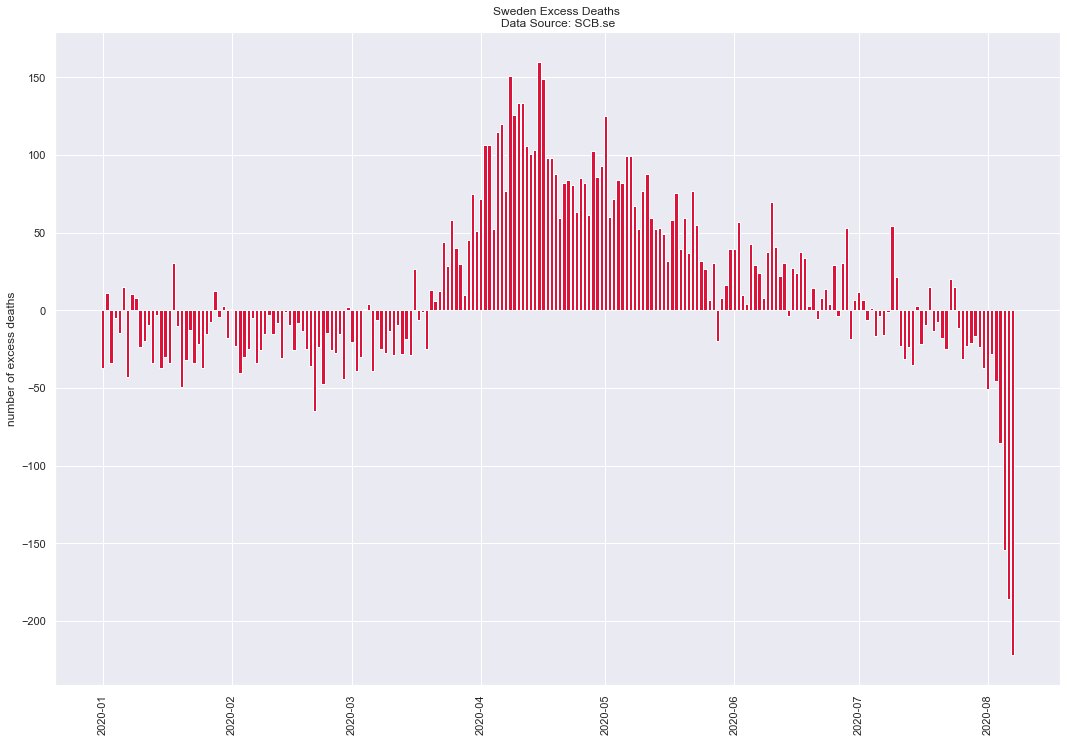

In [23]:
df_until_last_day.index = df_until_last_day.index
plt.figure(figsize=(18,12))
plt.title('Sweden Excess Deaths \nData Source: SCB.se')
plt.bar(df_until_last_day.index,df_until_last_day['excess_deaths'],color='crimson')
plt.xticks(rotation=90)
plt.ylabel('number of excess deaths')
plt.savefig('SCB_excess_daily_{}.jpg'.format(last_day),format='jpg')

2020-06-09    3909.534827
2020-06-10    3979.011191
2020-06-11    4019.736030
2020-06-12    4042.056964
2020-06-13    4072.597077
2020-06-14    4069.234380
2020-06-15    4096.678871
2020-06-16    4121.020808
2020-06-17    4158.733205
2020-06-18    4192.341213
2020-06-19    4195.148965
2020-06-20    4209.250722
2020-06-21    4203.849694
2020-06-22    4211.791400
2020-06-23    4225.844635
2020-06-24    4229.692349
2020-06-25    4259.209829
2020-06-26    4255.888723
2020-06-27    4286.404575
2020-06-28    4339.491106
2020-06-29    4320.743879
2020-06-30    4327.669885
2020-07-01    4339.750639
2020-07-02    4346.704372
2020-07-03    4340.304974
2020-07-04    4342.124753
2020-07-05    4325.471311
2020-07-06    4322.160603
2020-07-07    4306.533259
2020-07-08    4305.243553
2020-07-09    4359.318057
2020-07-10    4380.585167
2020-07-11    4357.785538
2020-07-12    4326.784060
2020-07-13    4302.979129
2020-07-14    4267.849000
2020-07-15    4270.663684
2020-07-16    4248.855493
2020-07-17  

AttributeError: 'str' object has no attribute 'date'

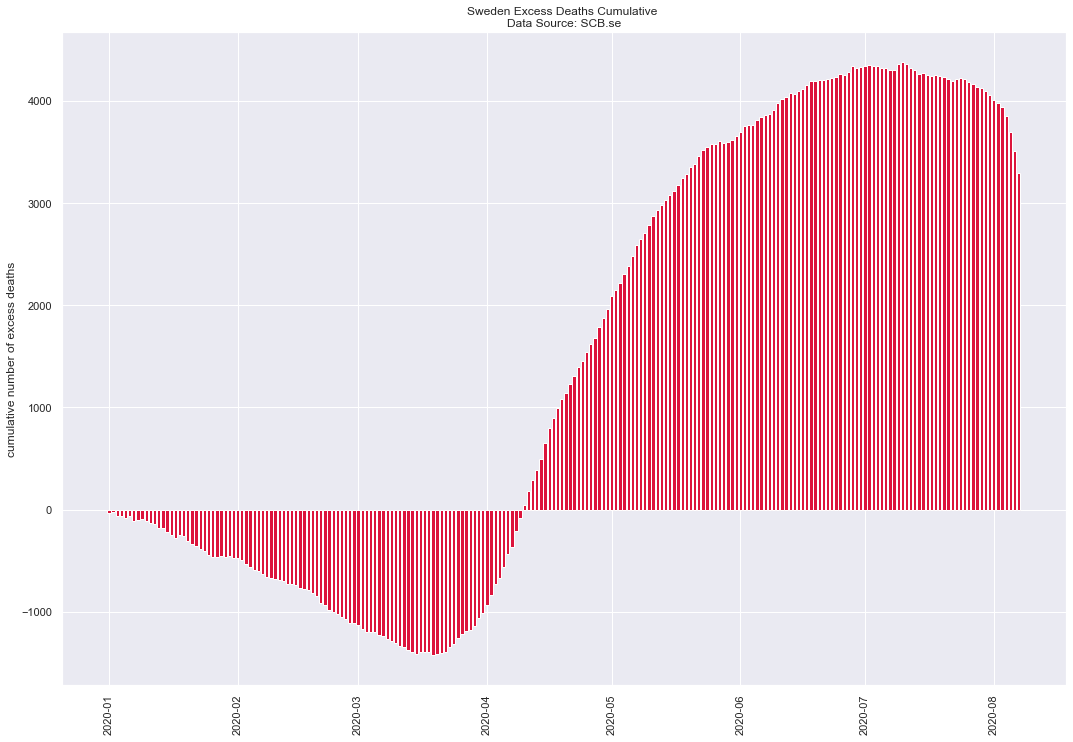

In [24]:
plt.figure(figsize=(18,12))
plt.title('Sweden Excess Deaths Cumulative \nData Source: SCB.se')
plt.bar(df_until_last_day.index,df_until_last_day['cum_excess'],color='crimson')
plt.xticks(rotation=90)
plt.ylabel('cumulative number of excess deaths')
print (df_until_last_day['cum_excess'].tail(60))
plt.savefig('SCB_excess_daily_cumsum_{}.jpg'.format(last_day.date()),format='jpg')

In [ ]:
df_until_last_day.index = pd.to_datetime(df_until_last_day.index)

### skip the last 7 days since they are likely to be updated ### 

last_week = df_until_last_day.index[-1] - pd.DateOffset(weeks=1)
last_week = last_week.date()

until_last_week = df_until_last_day[:last_week]
until_last_week.tail(40)

weekly = until_last_week['excess_deaths'].resample('W').sum()
weekly

In [ ]:
#plt.figure(figsize=(18,12))
#plt.bar(weekly.index,weekly,color='crimson')
weekly.index = weekly.index.date
weekly.plot.bar(figsize=(18,12),color='crimson',title='Sweden Excess Deaths 2020 by week\n Data Source: SCB.se')
plt.ylabel('nr of excess deaths')
plt.savefig('SCB_excess_weekly_{}.jpg'.format(last_day.date()),format='jpg')


In [ ]:
latest = weekly.cumsum()[-1]
weekly.cumsum().plot.bar(figsize=(18,12),color='crimson',
                         title='Sweden cumulative excess deaths for year 2020, currently: {} \n Data Source: SCB.se'.format(latest))
print (weekly.cumsum())
plt.ylabel('total number of excess deaths')
plt.savefig('SCB_excess_weekly_cumsum_{}.jpg'.format(last_day.date()),format='jpg')


In [25]:
df

,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,-36.957043
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,11.266075
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,-33.882216
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,-5.193076
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,-14.421022
...,...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438,-45.425763
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492,-85.415839
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860,-154.167839
2020-08-06,217.229470,218.691196,221.269628,205.421237,237.996784,33.861218,219.865807,-186.004589


In [26]:
# 2019 flu season

df['excess_2019'] = df['2019'] - df['2015-2019']
df

,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths,excess_2019
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,-36.957043,11.500920
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,11.266075,-12.203387
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,-33.882216,-17.354833
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,-5.193076,6.249927
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,-14.421022,-3.007360
...,...,...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438,-45.425763,7.835744
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492,-85.415839,-28.163116
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860,-154.167839,-5.504413
2020-08-06,217.229470,218.691196,221.269628,205.421237,237.996784,33.861218,219.865807,-186.004589,18.130977


In [27]:
df.sum()

2015             56225.049180
2016             55005.945355
2017             56284.437158
2018             57237.546448
2019             53487.459016
2020             59134.000000
2015-2019        55842.846995
excess_deaths     3291.153005
excess_2019      -2355.387978
dtype: float64

In [28]:
df_weekly = df.resample('W').sum()
df_weekly['2020_cum'] = df_weekly['excess_deaths'].cumsum()
df_weekly['2019_cum'] = df_weekly['excess_2019'].cumsum()
df_weekly.index = df_weekly.index - pd.DateOffset(years=1)

df_weekly

,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths,excess_2019,2020_cum,2019_cum
2019-01-05,1386.227133,1359.155563,1613.424369,1497.520820,1446.525907,1382.153358,1461.340640,-79.187283,-14.814734,-79.187283,-14.814734
2019-01-12,2005.583716,1952.891940,2176.842402,1964.854135,1902.943982,1939.324310,2001.290156,-61.965846,-98.346175,-141.153129,-113.160908
2019-01-19,1942.940799,1935.519275,2164.549645,2023.399187,1888.519934,1874.680167,1992.086471,-117.406305,-103.566537,-258.559434,-216.727446
2019-01-26,1952.034126,2043.842952,2006.792596,1969.989665,1911.186294,1775.148707,1976.746997,-201.598289,-65.560702,-460.157723,-282.288148
2019-02-02,2013.666673,1967.198841,1961.719153,1899.119339,1808.157384,1895.202117,1930.728572,-35.526455,-122.571188,-495.684178,-404.859336
2019-02-09,1889.391208,1980.483820,1902.304161,2009.019701,1947.246413,1771.044317,1946.068047,-175.023730,1.178366,-670.707908,-403.680970
2019-02-16,2036.905174,1841.502499,1961.719153,2120.974275,1873.065597,1872.627972,1966.520680,-93.892708,-93.455083,-764.600616,-497.136052
2019-02-23,2125.817702,1899.752023,2159.427663,2145.624823,1864.823285,1821.323096,2039.127528,-217.804432,-174.304243,-982.405048,-671.440295
2019-03-01,1801.489051,1831.283285,1769.132625,1890.902489,1570.160600,1824.401388,1970.611207,-146.209818,-400.450607,-1128.614867,-1071.890902
2019-03-08,2062.164415,1970.264605,1981.182685,2271.958884,1749.430905,1872.627972,2006.403315,-133.775343,-256.972410,-1262.390210,-1328.863312


Text(0.5, 1.0, 'Excess deaths 2019')

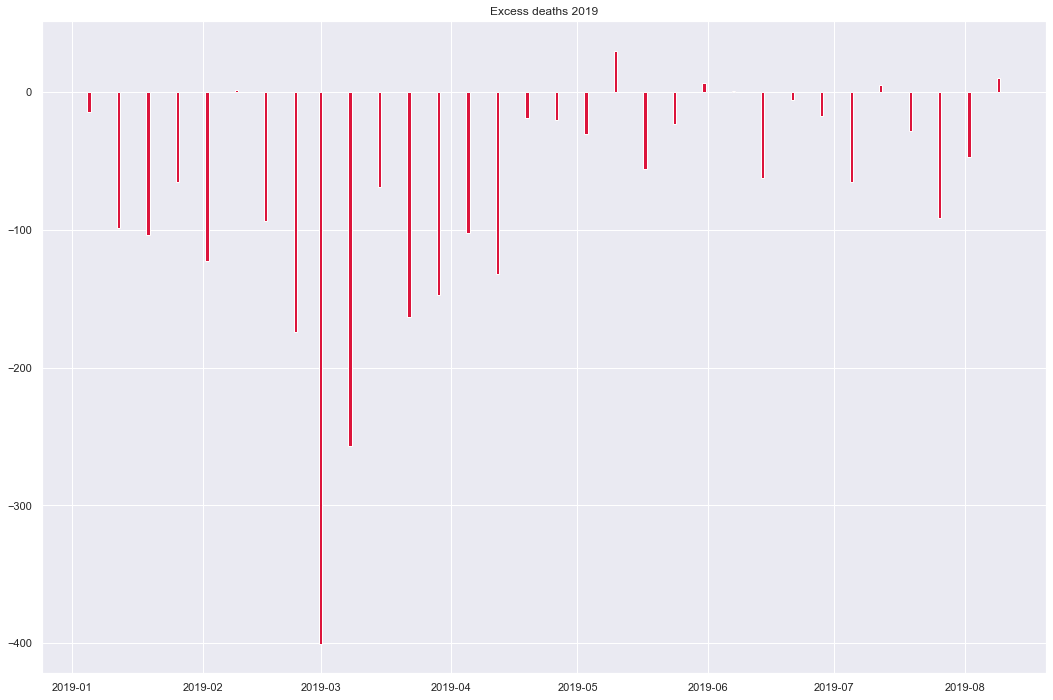

In [29]:
plt.figure(figsize=(18,12))
plt.bar(df_weekly.index,df_weekly['excess_2019'],color='crimson')
plt.title('Excess deaths 2019')

Text(0.5, 1.0, '2019 Excess Deaths Cumulative')

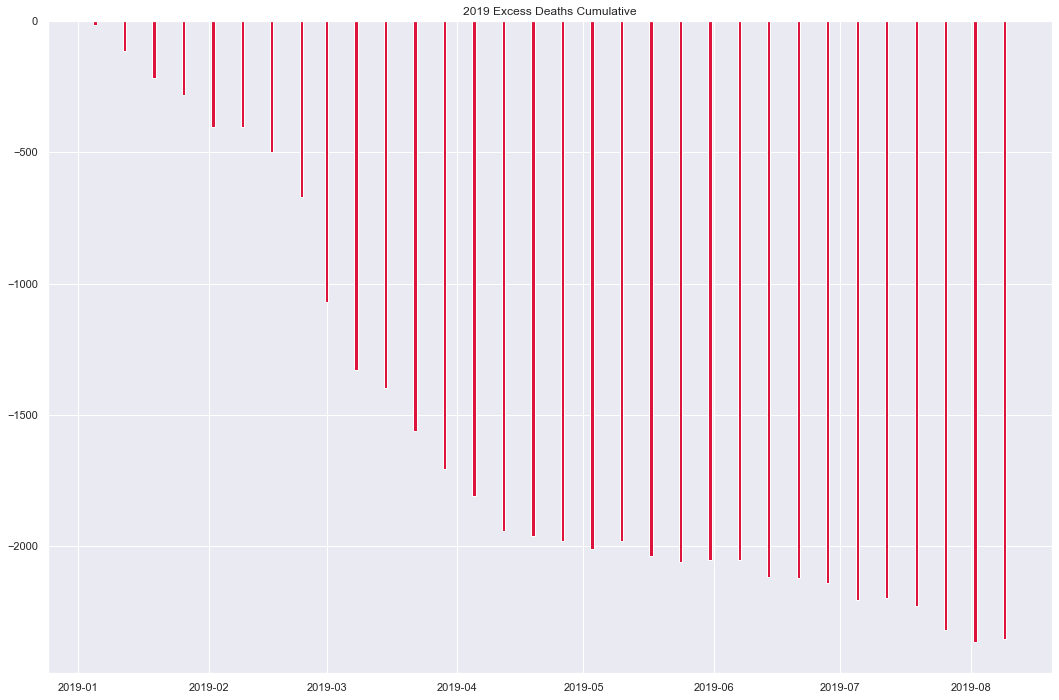

In [30]:
plt.figure(figsize=(18,12))
plt.bar(df_weekly.index,df_weekly['2019_cum'],color='crimson')
plt.title('2019 Excess Deaths Cumulative')

In [31]:
df

,2015,2016,2017,2018,2019,2020,2015-2019,excess_deaths,excess_2019
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,-36.957043,11.500920
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,11.266075,-12.203387
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,-33.882216,-17.354833
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,-5.193076,6.249927
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,-14.421022,-3.007360
...,...,...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438,-45.425763,7.835744
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492,-85.415839,-28.163116
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860,-154.167839,-5.504413
2020-08-06,217.229470,218.691196,221.269628,205.421237,237.996784,33.861218,219.865807,-186.004589,18.130977


In [32]:
print(df.loc['2020-10-01':,'excess_2019'].sum())
df.loc[:'2020-05-15',['excess_deaths','excess_2019']].sum()

0.0


excess_deaths    3083.738133
excess_2019     -2011.201918
dtype: float64

In [35]:
#### PARAM

start_day = pd.to_datetime(last_data_day) + pd.DateOffset(days=1) 

#####
start_period = pd.Timestamp(start_day)


df_19_2h = df.loc[start_period :,'2019']
df_19_2h.index = pd.date_range(start_period - pd.DateOffset(years=1),last_day)

dayname = df_19_2h.index[0].day_name()

df_20_1h = df.loc['2020-01-01' : start_period - pd.DateOffset(days=1),'2020']
print (df_20_1h)

df_19_20 = pd.concat([df_19_2h,df_20_1h])
df_19_20.sum()

ValueError: Length mismatch: Expected axis has 0 elements, new values have 366 elements

In [36]:
df_baseline_1h = df.loc[start_period :,'2015-2019']
df_baseline_1h.index = pd.date_range(start_period - pd.DateOffset(years=1),'2019-12-31')
df_baseline_2h = df.loc[:start_period - pd.DateOffset(days=1),'2015-2019']

df_baseline = pd.concat([df_baseline_1h,df_baseline_2h])
(df_19_20 - df_baseline).sum()

ValueError: Length mismatch: Expected axis has 0 elements, new values have 146 elements

In [ ]:
last_day = df_19_20.index[-1].date()
plt.figure(figsize=(18,12))
plt.title('Sweden Daily Deaths : season 2019/2020 vs baseline [Last day: {}]'.format(last_day))
plt.plot(df_19_20,'x--',color='crimson',label='2019/2020')
plt.plot(df_baseline,color='orange',label='Average 2015-2019')
plt.ylabel('# daily deaths')
plt.legend(loc='upper left')
plt.savefig('SCB_season_19_20.jpg',format='jpg')

In [ ]:
season_diff = df_19_20.sum() - df_baseline.sum()
print (season_diff)
plt.figure(figsize=(18,12))
plt.title('Sweden Cumulative Deaths : season 2019/2020 vs baseline [Last day: {}] season diff: {}\nData Source: SCB.se'.format(last_day,season_diff))
plt.plot(df_19_20.cumsum(),color='crimson',label='season 2019/2020')
plt.plot(df_baseline.cumsum(),color='orange',label='Average 2015-2019')
plt.legend(loc='upper left')
plt.ylabel('number of deaths, season diff:{}'.format(df_19_20.sum() - df_baseline.sum()))
plt.savefig('SCB_season_19_20_cumulative.jpg',format='jpg')

In [ ]:
print ('startday in 2019 calendar:',dayname)
previous_day = df_19_20.index[0] - pd.DateOffset(days=1)
print ('previous day:',previous_day)
day_code = 'W-' + previous_day.day_name()[:3].upper()
print (day_code)
df_weekly_19_20 = df_19_20.resample(day_code,convention='end').sum()
df_weekly_baseline = df_baseline.resample(day_code,convention='end').sum()
df_weekly_19_20.tail(40)

In [ ]:
#flu season

flu_baseline = df_baseline.loc['2019-12-01' : '2020-03-31']
flu_19_20 = df_19_20.loc['2019-12-01' : '2020-03-31']
print (flu_baseline.sum())
print (flu_19_20.sum())

flu = flu_19_20.sum() - flu_baseline.sum()
print (flu)

end_period = start_period - pd.DateOffset(days=1)
corona_baseline = df_baseline.loc['2020-04-01' : end_period].sum()
corona_19_20 = df_19_20.loc['2020-04-01' : end_period].sum()

corona = corona_19_20 - corona_baseline
print (corona)

In [ ]:
#note cut of last incomplete week
last_day = df_weekly_19_20.index[-2].date()

plt.figure(figsize=(18,12))
plt.title('Sweden Deaths per week season 19/20 vs baseline [Last day: {}]\nData Source: SCB.se'.format(last_day))
plt.ylabel('Number of deaths')
plt.plot(df_weekly_19_20[:-1],
         'x--',color='crimson',
         label='season 19/20 : non-flu deficit: {} Corona Excess: {} Delta: {}'.format(flu,corona,corona+flu))
plt.plot(df_weekly_baseline[:-1],'x--',color='orange',label='average 2015-2019')
plt.legend(loc='upper left')
plt.savefig('SCB_season_19_20_weekly.jpg',format='jpg')

In [ ]:
df_monthly_19_20 = df_19_20.resample('M').sum()
df_monthly_baseline = df_baseline.resample('M').sum()
print (df_monthly_19_20)
print (df_monthly_baseline)
print (df_monthly_19_20 - df_monthly_baseline)

plt.figure(figsize=(18,12))
plt.plot(df_monthly_19_20[1:-1],'x--',color='crimson')
plt.plot(df_monthly_baseline[1:-1],color='orange')